In [1]:
import polars as pl
import seaborn as sns
import numpy as np
import tarfile
import urllib.request
from pathlib import Path
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor, make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

In [2]:
sns.set(rc={'figure.figsize':(12, 6)})

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pl.read_csv(Path("datasets/housing/housing.csv"))

housing_data = load_housing_data()

housing_data = housing_data.with_columns(
    pl.when(pl.col('median_income') < 1.5)
    .then(1)
    .when(pl.col('median_income') < 3.0)
    .then(2)
    .when(pl.col('median_income') < 4.5)
    .then(3)
    .when(pl.col('median_income') < 6)
    .then(4)
    .otherwise(5)
    .alias("income_cat")
)

In [3]:
housing_data.head()

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32
-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,"""NEAR BAY""",5
-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,"""NEAR BAY""",5
-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,"""NEAR BAY""",5
-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,"""NEAR BAY""",4
-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,"""NEAR BAY""",3


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>],
       [<Axes: title={'center': 'income_cat'}>, <Axes: >, <Axes: >]],
      dtype=object)

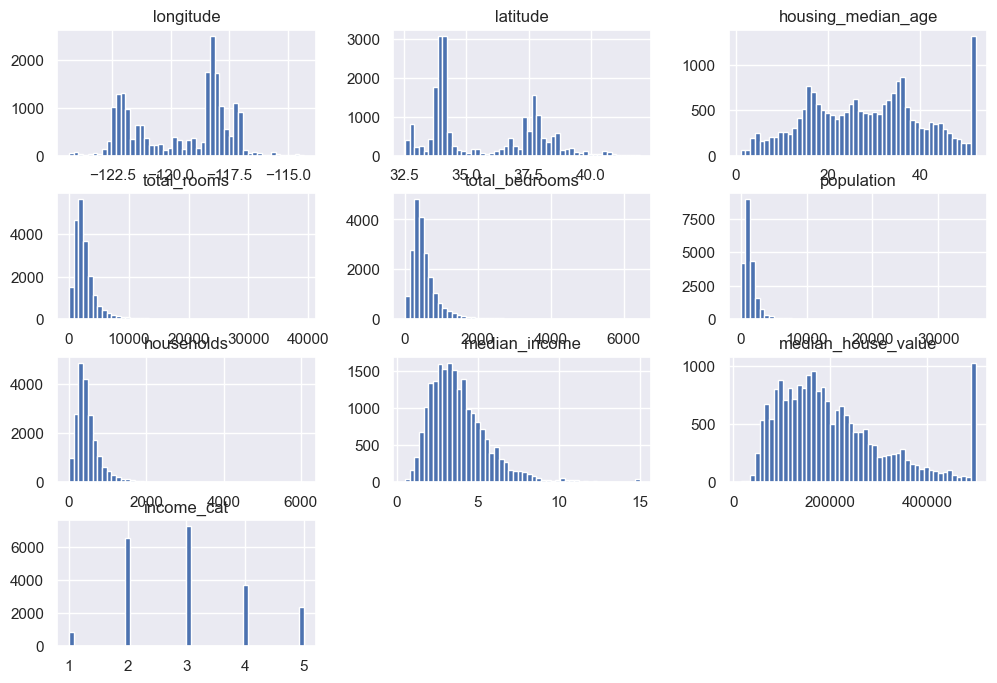

In [4]:
housing_data.to_pandas().hist(bins=50, figsize=(12,8))

<Axes: xlabel='income_cat', ylabel='count'>

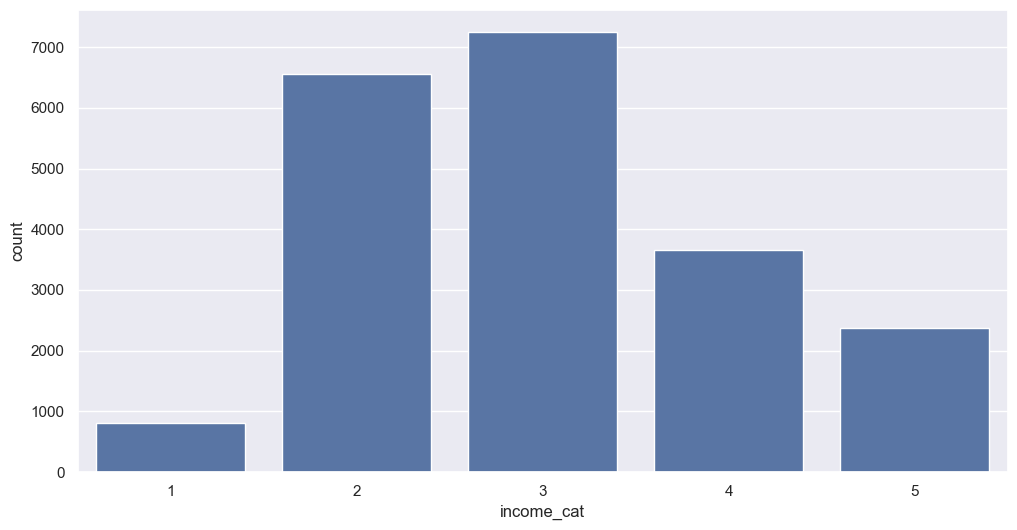

In [5]:
sns.countplot(data=housing_data.to_pandas(), x='income_cat')

In [6]:
train_set, test_set = train_test_split(housing_data, test_size=0.2, stratify=housing_data['income_cat'], random_state=2023)

train_set.drop_in_place('income_cat')
test_set.drop_in_place('income_cat')

income_cat
i32
5
2
2
3
5
3
2
2
2


<Axes: xlabel='longitude', ylabel='latitude'>

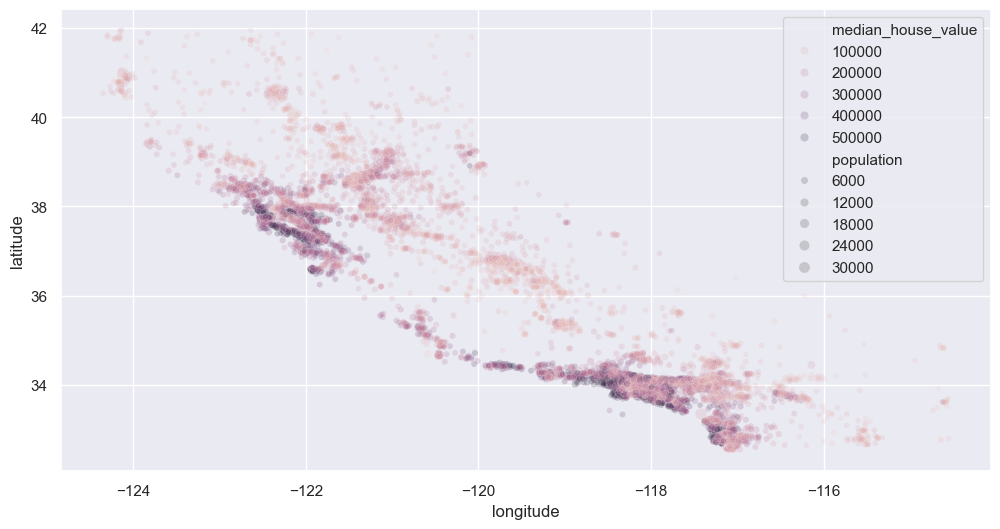

In [7]:
sns.scatterplot(data=train_set, x='longitude', y='latitude', size='population', hue='median_house_value', alpha=0.2)

array([[<Axes: xlabel='longitude', ylabel='longitude'>,
        <Axes: xlabel='latitude', ylabel='longitude'>,
        <Axes: xlabel='housing_median_age', ylabel='longitude'>,
        <Axes: xlabel='total_rooms', ylabel='longitude'>,
        <Axes: xlabel='total_bedrooms', ylabel='longitude'>,
        <Axes: xlabel='population', ylabel='longitude'>,
        <Axes: xlabel='households', ylabel='longitude'>,
        <Axes: xlabel='median_income', ylabel='longitude'>,
        <Axes: xlabel='median_house_value', ylabel='longitude'>,
        <Axes: xlabel='income_cat', ylabel='longitude'>],
       [<Axes: xlabel='longitude', ylabel='latitude'>,
        <Axes: xlabel='latitude', ylabel='latitude'>,
        <Axes: xlabel='housing_median_age', ylabel='latitude'>,
        <Axes: xlabel='total_rooms', ylabel='latitude'>,
        <Axes: xlabel='total_bedrooms', ylabel='latitude'>,
        <Axes: xlabel='population', ylabel='latitude'>,
        <Axes: xlabel='households', ylabel='latitude'>,
      

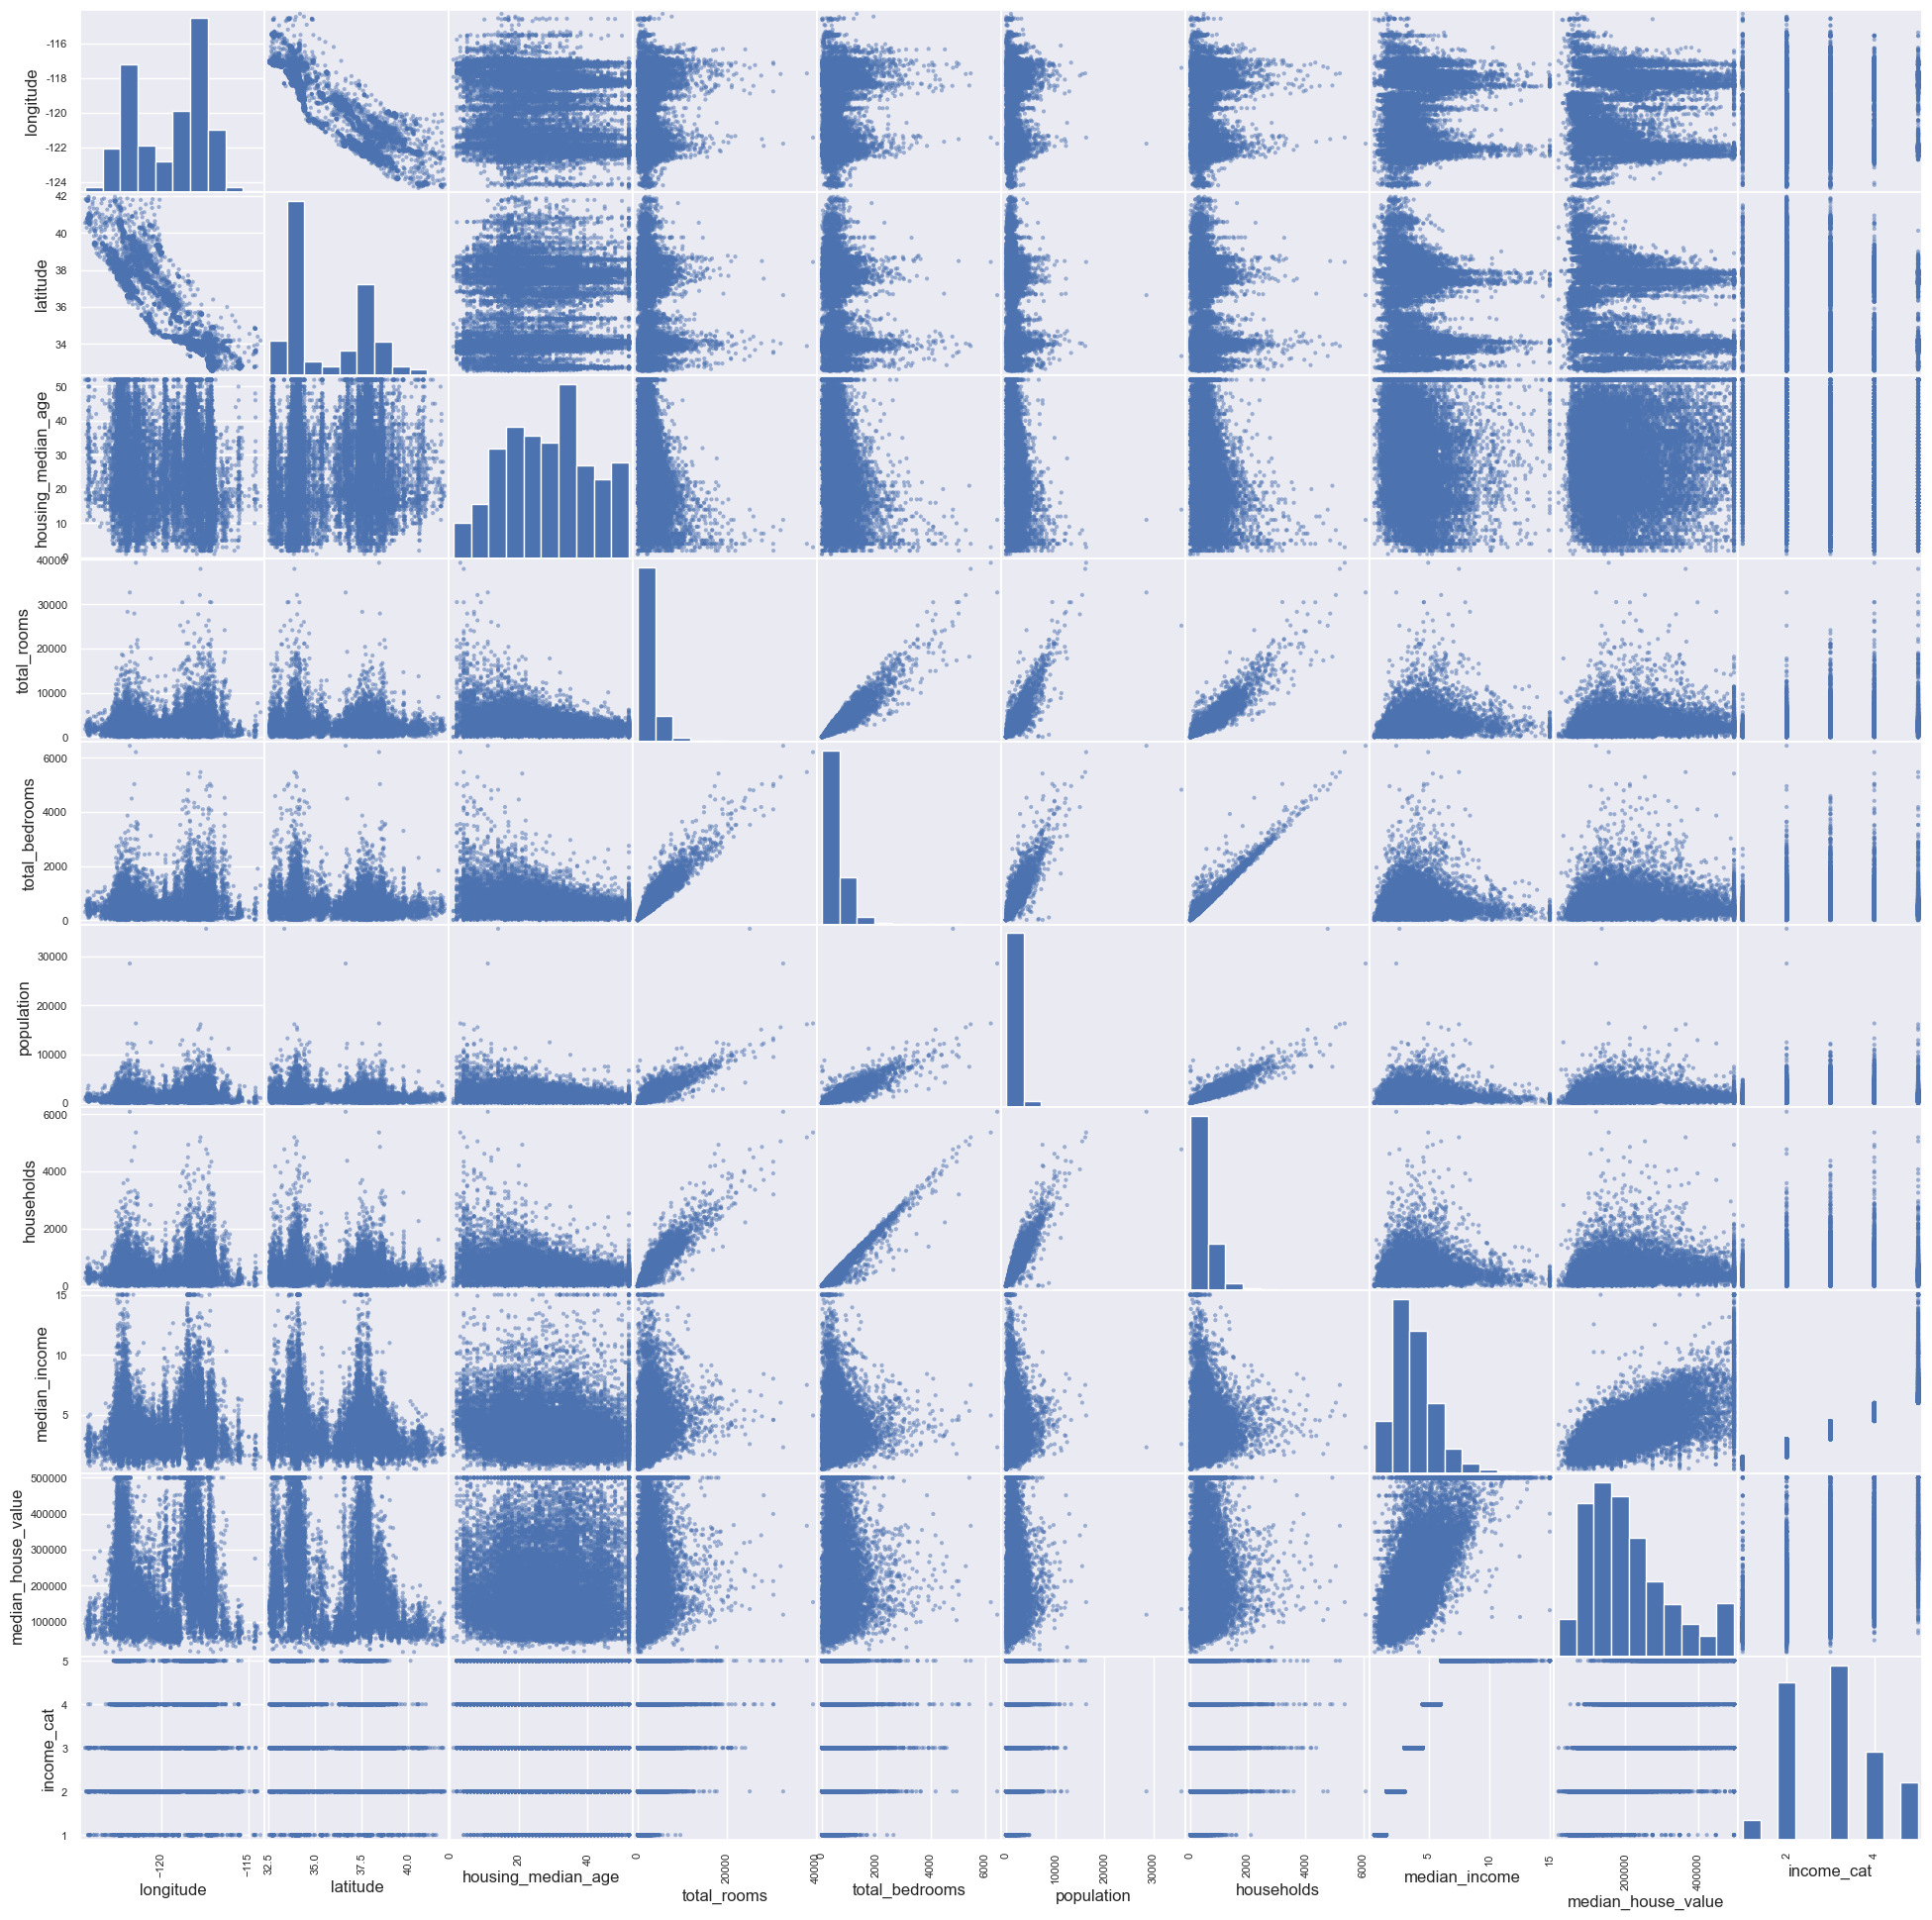

In [8]:
scatter_matrix(housing_data.to_pandas(), figsize=(24, 24))

<Axes: xlabel='median_income', ylabel='median_house_value'>

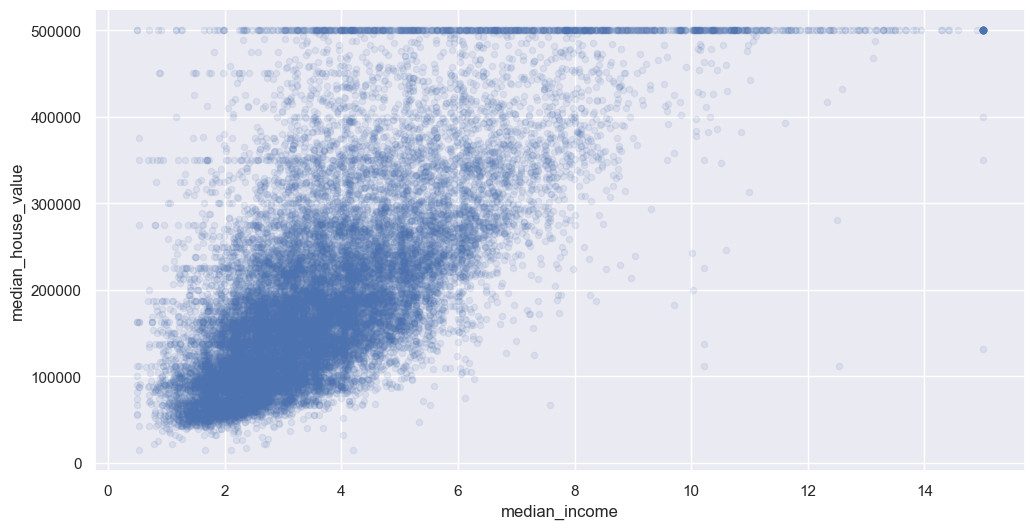

In [9]:
housing_data.to_pandas().plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)

In [10]:
housing_data.with_columns(
    rooms_per_house = (pl.col('total_rooms') / pl.col('households')),
    bedrooms_ratio = (pl.col('total_bedrooms') / pl.col('total_rooms')),
    people_per_house = (pl.col('population') / pl.col('households'))
).describe()

describe,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,rooms_per_house,bedrooms_ratio,people_per_house
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64
"""count""",20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,"""20640""",20640.0,20640.0,20640.0,20640.0
"""null_count""",0.0,0.0,0.0,0.0,207.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,207.0,0.0
"""mean""",-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.53968,3.870671,206855.816909,null,3.010562,5.429,0.213039,3.070655
"""std""",2.003532,2.135952,12.585558,2181.615252,421.38507,1132.462122,382.329753,1.899822,115395.615874,null,1.05454,2.474173,0.057983,10.38605
"""min""",-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,"""<1H OCEAN""",1.0,0.846154,0.1,0.692308
"""25%""",-121.8,33.93,18.0,1448.0,296.0,787.0,280.0,2.5637,119600.0,null,2.0,4.440748,0.175427,2.429787
"""50%""",-118.49,34.26,29.0,2127.0,435.0,1166.0,409.0,3.5349,179700.0,null,3.0,5.229167,0.203162,2.818182
"""75%""",-118.01,37.71,37.0,3148.0,647.0,1725.0,605.0,4.7437,264800.0,null,4.0,6.052381,0.239821,3.28227
"""max""",-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,"""NEAR OCEAN""",5.0,141.909091,1.0,1243.333333


In [11]:
imputer = SimpleImputer(strategy='median')

train_set_num = train_set.select(
    pl.col(pl.Float64)
)

imputer.fit(train_set_num)

X = imputer.transform(train_set_num)

housing_clean = pl.DataFrame(X, train_set_num.columns)

housing_clean.describe()

describe,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",16512.0,16512.0,16512.0,16512.0,16512.0,16512.0,16512.0,16512.0,16512.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-119.56649,35.631467,28.568193,2644.687803,538.205547,1430.490795,500.616824,3.867105,206732.827883
"""std""",2.00279,2.137893,12.584471,2191.997893,418.728535,1142.7219,380.520237,1.890981,115370.303979
"""min""",-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0
"""25%""",-121.79,33.93,18.0,1452.0,298.0,793.0,281.0,2.5625,119400.0
"""50%""",-118.49,34.26,29.0,2139.0,437.0,1170.0,411.0,3.5341,179500.0
"""75%""",-118.01,37.71,37.0,3161.0,646.0,1731.0,607.0,4.7557,265300.0
"""max""",-114.55,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0


In [12]:
train_set_cat = train_set.select(
    pl.col(pl.Utf8)
)

cat_encoder = OneHotEncoder()
houseing_cat_encoded = cat_encoder.fit_transform(train_set_cat)

houseing_cat_encoded

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [13]:
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

model.fit(housing_clean.select('median_income'), housing_clean.select('median_house_value'))

pred = model.predict(test_set.select('median_income'))

pred


array([[300639.23504882],
       [160509.52835845],
       [123371.20163832],
       ...,
       [164095.73072455],
       [257809.8520651 ],
       [140557.35463433]])

<Axes: ylabel='Count'>

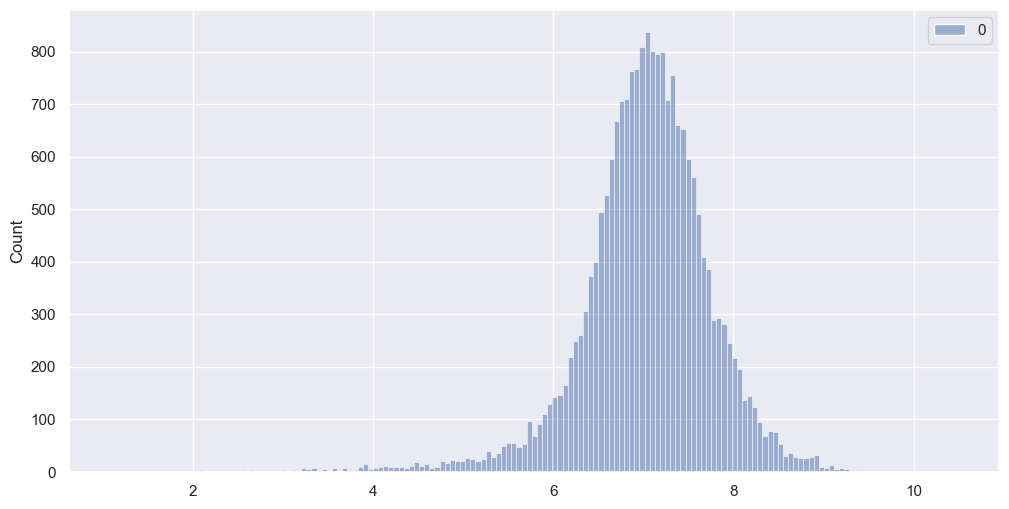

In [14]:
log_trans = FunctionTransformer(func = np.log, inverse_func=np.exp)
log_pop = log_trans.transform(housing_data.select('population'))
sns.histplot(data=log_pop)

<Axes: ylabel='Count'>

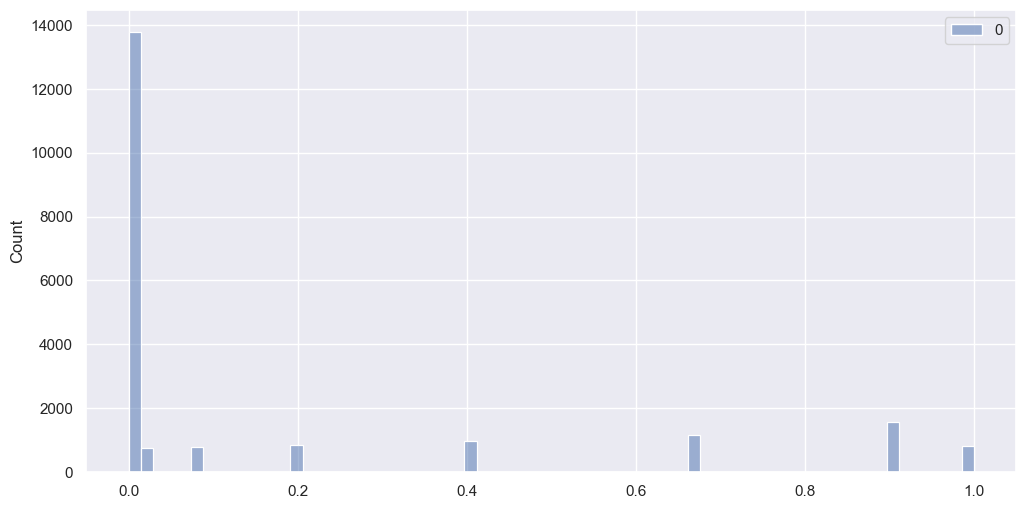

In [15]:
rbf_trans = FunctionTransformer(
    rbf_kernel,
    kw_args=dict(Y=[[35.]], gamma=0.1)
)

age_simil_35 = rbf_trans.transform(housing_data.select('housing_median_age'))

sns.histplot(age_simil_35)

<Axes: ylabel='Count'>

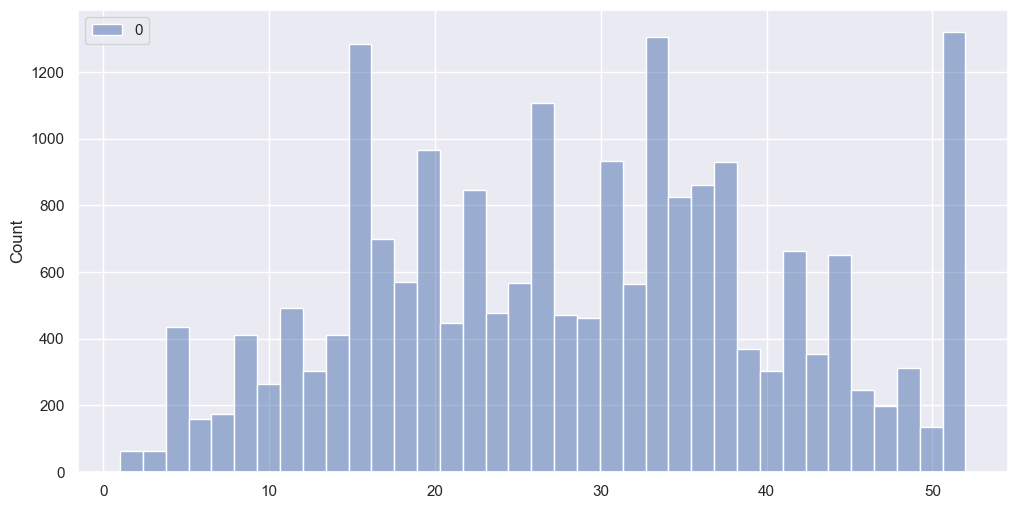

In [16]:
sns.histplot(housing_data.select("housing_median_age"))

In [17]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [18]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None) -> None:
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state, n_init='auto')
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [19]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )
    
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=2023)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
    ],
    remainder=default_num_pipeline)

In [20]:
train_set_y = train_set.select("median_house_value")
train_set.drop_in_place('median_house_value')

housing_prepared = preprocessing.fit_transform(train_set.to_pandas())
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

scores = []

for reg_model in [
    LinearRegression(),
    LinearSVR(random_state=2023),
    NuSVR(),
    DecisionTreeRegressor(random_state=2023),
    RandomForestRegressor(random_state=2023)]:
    new_pipeline = make_pipeline(
        preprocessing,
        reg_model
    )   
    print(f"Now testing {reg_model}")
    score = -cross_val_score(new_pipeline,
                         X=train_set.to_pandas(),
                         y=train_set_y.to_pandas().shape,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
    
    print(f"CV score: {score}")
    scores.append(score)
    
print(scores)
    

Now testing LinearRegression()
CV score: [66052.07904547 69245.73071196 70118.57663293 71967.45322871
 76105.33269396 69376.85948837 70742.44567611 68338.55781723
 67843.28714662 78485.93725416]
Now testing LinearSVR(random_state=2023)


d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.

CV score: [209304.75142381 215576.29824303 216418.45465875 221829.93761861
 214282.05124799 215234.01188928 215585.75104606 211862.38164361
 218047.7165037  211251.67062952]
Now testing NuSVR()


d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

CV score: [112964.94773515 116003.12140662 117748.10201639 119613.09816277
 113351.81888459 115900.75536749 115534.16331494 116362.7724155
 118020.86918859 113910.02819911]
Now testing DecisionTreeRegressor(random_state=2023)
CV score: [65102.41045753 67741.81959433 67045.6475997  74014.75932123
 65743.73818848 65124.63028545 69454.05030647 67522.81585313
 67276.32174486 65054.6109044 ]
Now testing RandomForestRegressor(random_state=2023)


d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\dev\ks-portfolio\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

CV score: [45034.52807432 47803.98806507 47429.21138538 51221.60176988
 48198.48335457 47860.50407875 49276.9670329  48026.33302782
 44208.86462722 44797.5321589 ]
[array([66052.07904547, 69245.73071196, 70118.57663293, 71967.45322871,
       76105.33269396, 69376.85948837, 70742.44567611, 68338.55781723,
       67843.28714662, 78485.93725416]), array([209304.75142381, 215576.29824303, 216418.45465875, 221829.93761861,
       214282.05124799, 215234.01188928, 215585.75104606, 211862.38164361,
       218047.7165037 , 211251.67062952]), array([112964.94773515, 116003.12140662, 117748.10201639, 119613.09816277,
       113351.81888459, 115900.75536749, 115534.16331494, 116362.7724155 ,
       118020.86918859, 113910.02819911]), array([65102.41045753, 67741.81959433, 67045.6475997 , 74014.75932123,
       65743.73818848, 65124.63028545, 69454.05030647, 67522.81585313,
       67276.32174486, 65054.6109044 ]), array([45034.52807432, 47803.98806507, 47429.21138538, 51221.60176988,
       48198